In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import geopandas as gpd

import rasterio as rs
from rasterio import mask
import scipy.ndimage
from PIL import Image

import os,sys

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [62]:
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'Lato',
    'text.color': 'black',
    'axes.facecolor':'white',
    'figure.facecolor':'white',
    'axes.titlesize': 12,
    # 'axes.labelsize': 8
    # 'xtick.labelsize': 10,
    # 'ytick.labelsize': 10
})

# Reading image
When the image is big (high resolution) enough to plot for the big area, the best solution would do downsampling to avoid any memory crash

In [5]:
rast = rs.open('../../../concat_img_merged_2000.tif')
downscale_factor = 5
img = rast.read([3,2,1],out_shape=(
                3,
                int(rast.height / downscale_factor),
                int(rast.width / downscale_factor)
                                    ),
            resampling=0
            )

# Steps to prepare the image to plot
* Move axis to match the `imshow` requirment
* Normlize the data between 0-1 (Landsat data are scaled between 0-40,000)
* To make it brighter, it is recommended to multiply the image by a nummber
* Range the data between 0-1 in case there are values bigger than 1
* If the image includes `NAN` to avoid black PXs, it is possible to replace them with 1

In [6]:
img = np.clip(np.moveaxis(img,0,2)*5/40000,0,1)

In [40]:
# The bounding box in data coordinates that the image will fill. The image is stretched individually along x and y to fill the box.
minx, miny, maxx, maxy = rast.bounds

In [43]:
minx, miny, maxx, maxy

(4005195.2978272187, 2431955.6362599344, 4400055.297827219, 2773295.6362599344)

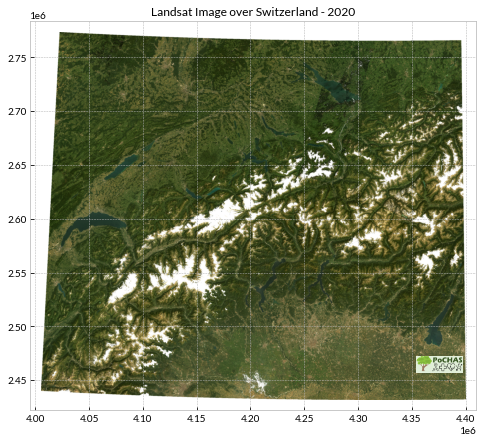

In [72]:
fig = plt.figure(1,figsize=(8,8))
plt.imshow(np.where(img==0,1,img),extent=(minx, maxx, miny, maxy))
plt.title('Landsat Image over Switzerland - 2020' )
plt.tick_params(labelsize=10,labelbottom=True,labelleft=True)
plt.xlim(minx-10e3, maxx+10e3)
plt.ylim(miny-10e3, maxy+10e3)


logo = Image.open('../../../Logo_design.png')
tmp_ax = fig.add_axes([0.795, 0.18, 0.08, 0.08], anchor='NE', zorder=+1)
tmp_ax.imshow(logo, alpha=1)
tmp_ax.axis('off')
plt.show()

# Mask the AOI and plot it
* One of the chaleenages after clipping the raster is its high resolution which makes calculation tough. `scipy.ndimage.zoom` can be used for downsampling\
https://www.geeksforgeeks.org/how-to-resample-numpy-array-representing-an-image/

In [8]:
def clip_area_of_interest(geom):
    rast = rs.open('../../../concat_img_merged_2000.tif')
    out_image, out_transform = mask.mask(rast, geom, crop=True,nodata=-1)
    return out_image

In [20]:
aoi = gpd.read_file('../../../CHE_3035.geojson')
img_ = clip_area_of_interest(aoi['geometry'])
img_ = scipy.ndimage.zoom(img_, (1,0.20,0.20), order = 3)
img_ = np.clip(np.moveaxis(img_[[2,1,0],:,:],0,2)*5/40000,0,1)

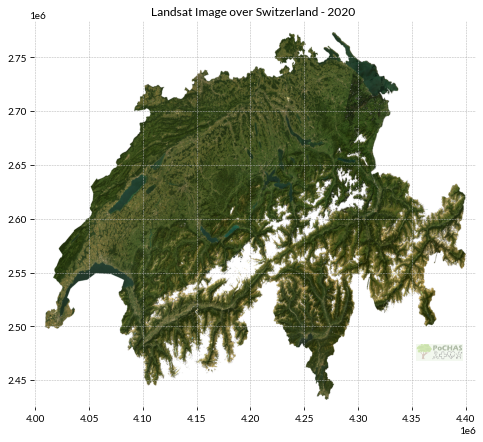

In [80]:
fig = plt.figure(1,figsize=(8,8))
plt.imshow(img_,extent=(minx, maxx, miny, maxy))
plt.title('Landsat Image over Switzerland - 2020')
plt.xlim(minx-10e3, maxx+10e3)
plt.ylim(miny-10e3, maxy+10e3)
plt.tick_params(labelsize=10,labelbottom=True,labelleft=True)


logo = Image.open('../../../Logo_design.png')
tmp_ax = fig.add_axes([0.795, 0.20, 0.08, 0.08], anchor='NE', zorder=+1)
tmp_ax.imshow(logo, alpha=.40)
tmp_ax.axis('off')

sns.despine(left=True, bottom=True);
plt.show()

# Plotting the vector on the image

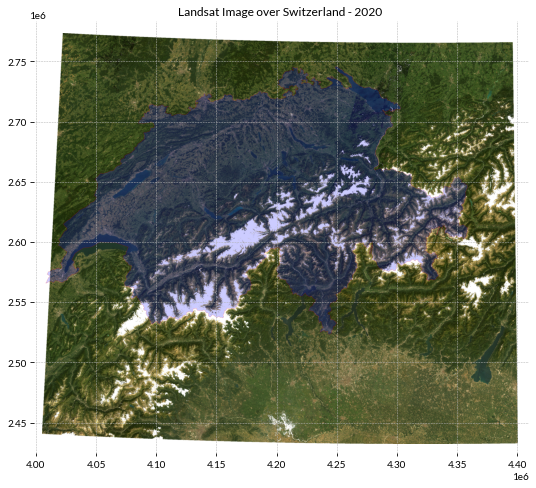

In [79]:
fig = plt.figure(1,figsize=(12,8))
plt.imshow(np.where(img==0,1,img),extent=(minx, maxx, miny, maxy))
aoi.plot(ax=plt.gca(),alpha=0.2,edgecolor='red')

plt.xlim(minx-10e3, maxx+10e3)
plt.ylim(miny-10e3, maxy+10e3)
plt.tick_params(labelsize=10,labelbottom=True,labelleft=True)

plt.title('Landsat Image over Switzerland - 2020')
sns.despine(left=True, bottom=True);
plt.show()

# Multipanel Plotting

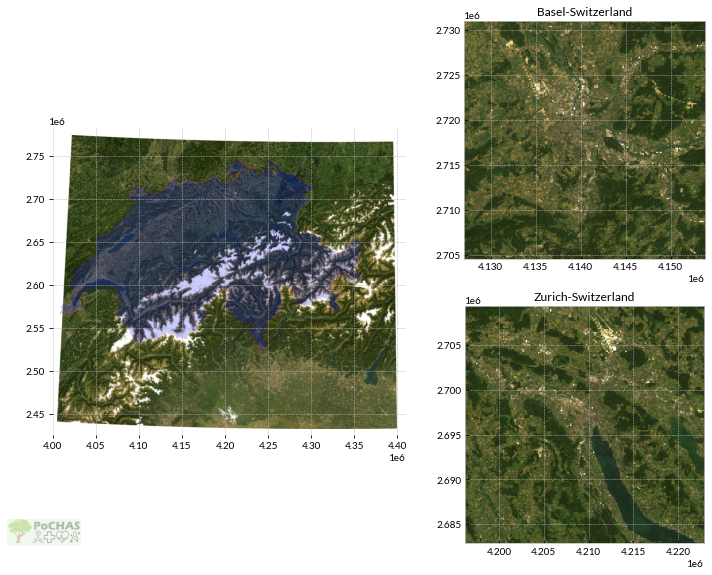

In [120]:
fig = plt.figure(1, figsize=([12.8, 9.6]))
gs = plt.GridSpec(4,4, wspace=0, hspace=0.50)

# Panel 01
xtr_subsplot= fig.add_subplot(gs[0:4,0:2])
plt.imshow(np.where(img==0,1,img),extent=(minx, maxx, miny, maxy))
aoi.plot(ax=plt.gca(),alpha=0.2,edgecolor='red')

plt.xlim(minx-10e3, maxx+10e3)
plt.ylim(miny-10e3, maxy+10e3)
plt.tick_params(labelsize=10,labelbottom=True,labelleft=True)
sns.despine(left=True, bottom=True);

# Panel 02
xtr_subsplot = fig.add_subplot(gs[0:2,2:4])
plt.imshow(np.where(img==0,1,img),extent=(minx, maxx, miny, maxy))

plt.xlim(4137003.0508-10e3, 4143839.7353+10e3)
plt.ylim(2714544.3778-10e3, 2720918.2099+10e3)
plt.tick_params(labelsize=10,labelbottom=True,labelleft=True)

plt.title('Basel-Switzerland')

# Panel 03
xtr_subsplot = fig.add_subplot(gs[2:4,2:4])
plt.imshow(np.where(img==0,1,img),extent=(minx, maxx, miny, maxy))

plt.xlim(4206147.8472-10e3, 4212918.0645+10e3)
plt.ylim(2692843.3169-10e3, 2699361.9776+10e3)
plt.tick_params(labelsize=10,labelbottom=True,labelleft=True)

plt.title('Zurich-Switzerland')

logo = Image.open('../../../Logo_design.png')
tmp_ax = fig.add_axes([0.08, 0.08, 0.08, 0.08], anchor='NW', zorder=+1)
tmp_ax.imshow(logo, alpha=.40)
tmp_ax.axis('off')
      
plt.show()


## TODO:
* Create a GIF using NDVI
* Multipanel with GIF